In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
from PIL import Image
import torchvision.transforms as T
from tqdm import tqdm

In [3]:
import os, sys
sys.path.insert(0,os.path.realpath(os.path.pardir))

In [ ]:
from utils.config import cfg
device = cfg.GLOBAL.DEVICE

from utils.utils import *
rebuild_bkk_pkl()

In [4]:
def radar_colormap():
    nws_reflectivity_colors = np.array([
    (165, 151, 95), # ND
    (0, 255, 128), # 5.5
    (0, 255, 0), # 10
    (0, 175, 0), # 15
    (0, 150, 50), # 20
    (255, 255, 0), # 25
    (255, 200, 0), # 30
    (255, 170, 0), # 35
    (255, 85, 0), # 40
    (255, 0, 0), # 45
    (255, 0, 100), # 50
    (255, 0, 255), # 55
    (255, 128, 255), # 60
    (255, 200, 255), # 65
    (255, 225, 255), # 70
    (255, 255, 255) # 75
    ])
    return torch.tensor(nws_reflectivity_colors).to(device)
    # return mpl.colors.ListedColormap(nws_reflectivity_colors)

dBZmap = torch.tensor([0,5.5,10,15,20,25,30,35,40,45,50,55,60,65,70,75]).to(device)
dBZmap = dBZmap * 255. / 75.

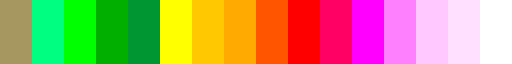

In [5]:
mpl.colors.ListedColormap(radar_colormap().cpu().numpy()/255)

In [6]:
def color2dBZ(rgb, dBZmap):
    w, h, c = rgb.shape
    rgb = rgb.reshape(-1, c)[:,:3]
    rgb = torch.Tensor(rgb).to(device)
    cmap = radar_colormap().unsqueeze(0).to(device)
    repeated_rgb = rgb.unsqueeze(1).repeat(1,16,1).to(device)
    # print(repeated_rgb.shape, cmap.shape)
    rgb_diff2 = ((repeated_rgb - cmap)**2).mean(axis=2)
    return dBZmap[torch.argmin(rgb_diff2,axis=1).to(device)].reshape(w, h, 1)

transform = T.ToPILImage()

def convert_n_save(df, path, idx):
    data = df.iloc[idx]
    rgb_img = Image.open(f"..{data.FolderPath}{data.FileName}")
    rgb_img = np.asarray(rgb_img)
    dBZ_img = color2dBZ(rgb_img, dBZmap)
    dBZ_img = transform(dBZ_img.permute(2,0,1))
    dBZ_img.save(f"{path}{data.FileName}")

In [11]:
filenames = pd.read_pickle(cfg.ONM_PD.FOLDER_ALL)

In [12]:
filenames

,FileName,RADAR_RGB_PNG_PATH,RADAR_dBZ_PNG_PATH,RADAR_MASK_PATH
DateTime,,,,
2020-06-18 06:30:00,1592461954,bkk_radar_images_1,bkk_radar_images_dBZ_1,bkk_radar_images_mask_1
2020-06-18 06:35:00,1592462136,bkk_radar_images_1,bkk_radar_images_dBZ_1,bkk_radar_images_mask_1
2020-06-18 06:45:00,1592462768,bkk_radar_images_1,bkk_radar_images_dBZ_1,bkk_radar_images_mask_1
2020-06-18 06:50:00,1592463068,bkk_radar_images_1,bkk_radar_images_dBZ_1,bkk_radar_images_mask_1
2020-06-18 06:55:00,1592463277,bkk_radar_images_1,bkk_radar_images_dBZ_1,bkk_radar_images_mask_1
...,...,...,...,...
2021-06-28 20:05:00,1624910840,bkk_radar_images_13,bkk_radar_images_dBZ_13,bkk_radar_images_mask_13
2021-06-28 20:35:00,1624912646,bkk_radar_images_13,bkk_radar_images_dBZ_13,bkk_radar_images_mask_13
2021-06-28 20:45:00,1624913244,bkk_radar_images_13,bkk_radar_images_dBZ_13,bkk_radar_images_mask_13


### Set folder_i to bkk_radar_images_{i} in order to convert from RGB to dBZ

In [ ]:
folder_i = 8

df = None
newPath = None
exec(f"df = filenames_{folder_i}")
exec(f"newPath = os.path.join(cfg.RADAR_dBZ_PNG_PATH, 'bkk_radar_images_dBZ_{folder_i}')")

for idx in tqdm(range(df.shape[0])):
    convert_n_save(df, newPath, idx)